# download sequence

In [4]:
import pandas as pd
import os
import requests

# === Parameters ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/SI/training_set/504_PPI_dimer.csv"  # 🔁 Replace with your actual CSV path
output_dir = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Training_set"  # Folder to save .fasta files
pdb_column = "PDB"  # Column name in CSV

# === Create output directory if not exists ===
os.makedirs(output_dir, exist_ok=True)

# === Load CSV ===
df = pd.read_csv(csv_path)
pdb_ids = df[pdb_column].dropna().unique()

# === Download and save FASTA for each PDB ID ===
for pdb_id in pdb_ids:
    pdb_id = pdb_id.strip().lower()
    url = f"https://www.rcsb.org/fasta/entry/{pdb_id}"
    response = requests.get(url)

    if response.status_code == 200 and response.text.startswith(">"):
        fasta_path = os.path.join(output_dir, f"{pdb_id}.fasta")
        with open(fasta_path, "w") as f:
            f.write(response.text)
        print(f"✅ Saved: {pdb_id}.fasta")
    else:
        print(f"❌ Failed to download FASTA for {pdb_id} (status: {response.status_code})")

✅ Saved: 2p45.fasta
✅ Saved: 3f1p.fasta
✅ Saved: 2p49.fasta
✅ Saved: 2uyz.fasta
✅ Saved: 3knb.fasta
✅ Saved: 2v52.fasta
✅ Saved: 3fp6.fasta
✅ Saved: 1lw6.fasta
✅ Saved: 2j12.fasta
✅ Saved: 2wwx.fasta
✅ Saved: 4z9k.fasta
✅ Saved: 4h6j.fasta
✅ Saved: 5ky0.fasta
✅ Saved: 5b77.fasta
✅ Saved: 6gvk.fasta
✅ Saved: 3n4i.fasta
✅ Saved: 5vwy.fasta
✅ Saved: 6er6.fasta
✅ Saved: 5d1m.fasta
✅ Saved: 6fp7.fasta
✅ Saved: 6jwj.fasta
✅ Saved: 1j2j.fasta
✅ Saved: 1wqj.fasta
✅ Saved: 2g2u.fasta
✅ Saved: 2omz.fasta
✅ Saved: 2vln.fasta
✅ Saved: 2vlq.fasta
✅ Saved: 3sri.fasta
✅ Saved: 3uzq.fasta
✅ Saved: 5m72.fasta
✅ Saved: 6bw9.fasta
✅ Saved: 2ftl.fasta
✅ Saved: 3idb.fasta
✅ Saved: 4pas.fasta
✅ Saved: 5d1l.fasta
✅ Saved: 1zvy.fasta
✅ Saved: 2ptt.fasta
✅ Saved: 4cj1.fasta
✅ Saved: 6fbx.fasta
✅ Saved: 2p43.fasta
✅ Saved: 4apx.fasta
✅ Saved: 5b76.fasta
✅ Saved: 6jb8.fasta
✅ Saved: 6ne4.fasta
✅ Saved: 1t0p.fasta
✅ Saved: 4hdo.fasta
✅ Saved: 5l21.fasta
✅ Saved: 5l8j.fasta
✅ Saved: 2omx.fasta
✅ Saved: 2omy.fasta


### compare complex to complex

In [ ]:
import os
from Bio import SeqIO, pairwise2
from Bio.Align import substitution_matrices
import pandas as pd

def load_complex_seqs(fasta_dir):
    """
    For each multi-entry FASTA file, concatenate all chains into a single sequence.
    Returns dict {<filename>: <concatenated_sequence>} using the filename (no path) as the key.
    """
    complexes = {}
    for filename in os.listdir(fasta_dir):
        if filename.endswith((".fasta", ".fa")):
            path = os.path.join(fasta_dir, filename)
            seqs = []
            for record in SeqIO.parse(path, "fasta"):
                seqs.append(str(record.seq).upper())
            concat = "".join(seqs)
            if concat:  # skip empty files just in case
                complexes[filename] = concat
    return complexes

def compute_identity_nw(seq1, seq2, gap_open=-10, gap_extend=-0.5):
    """
    Compute global sequence identity with Needleman–Wunsch (BLOSUM62).
    Identity = matches / alignment length (including gaps).
    """
    if not seq1 or not seq2:
        return 0.0

    blosum62 = substitution_matrices.load("BLOSUM62")
    aln = pairwise2.align.globalds(seq1, seq2, blosum62, gap_open, gap_extend,
                                   one_alignment_only=True)[0]
    aligned1, aligned2 = aln[0], aln[1]
    matches = sum(a == b for a, b in zip(aligned1, aligned2))
    aligned_len = len(aligned1)
    return matches / aligned_len if aligned_len > 0 else 0.0

# === Set directories ===
train_dir = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/train_fastas"
test_dir  = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Contini_test_fastas"

# === Load complex (concatenated) sequences ===
train_complex = load_complex_seqs(train_dir)
test_complex  = load_complex_seqs(test_dir)

# === Compute best train match for each test complex ===
results = []
for test_name, test_seq in test_complex.items():
    best_match = None
    best_identity = 0.0
    for train_name, train_seq in train_complex.items():
        # Skip if the base filename (without extension) matches
        if os.path.splitext(test_name)[0] == os.path.splitext(train_name)[0]:
            continue

        identity = compute_identity_nw(test_seq, train_seq)
        if identity > best_identity:
            best_identity = identity
            best_match = train_name
    results.append({
        "Test Complex": test_name,
        "Best Matching Train Complex": best_match,
        "Percent Identity": round(best_identity * 100, 2)
    })

# === Save results ===
df = pd.DataFrame(results)
output_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Contini_sequence_identity_results_complex_vs_complex.csv"
df.to_csv(output_path, index=False)

print(f"\n✅ Done. Results saved to: {output_path}")


✅ Done. Results saved to: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Contini_sequence_identity_results_complex_vs_complex.csv


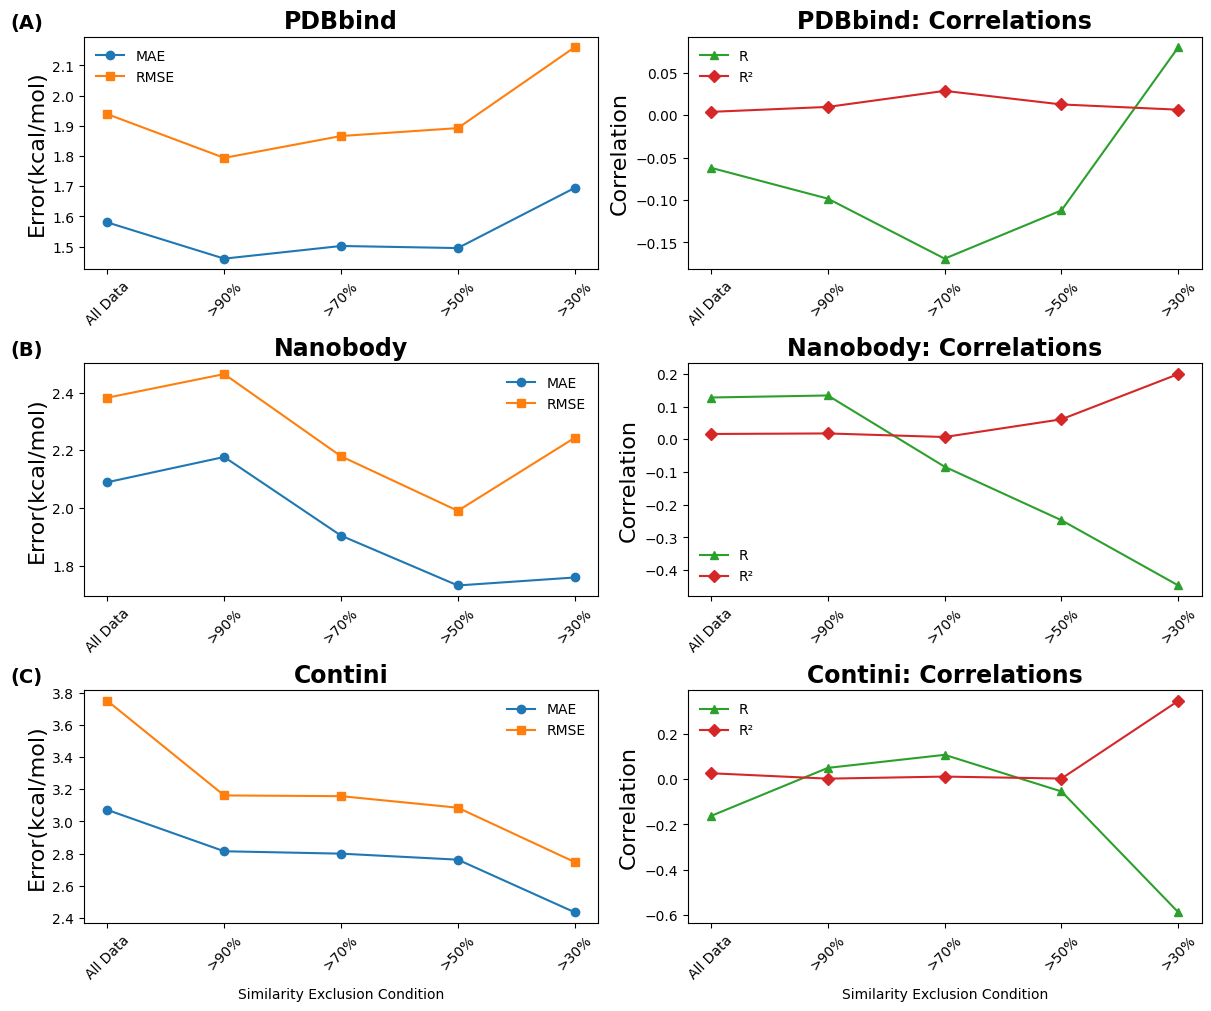

Saved 3x2 composite figure to: identity_exclusion_3x2.png


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- CONFIG ----------
datasets = [
    ("PDBbind", "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/PDBbind_metrics_by_identity_exclusion.csv", "A"),
    ("Nanobody", "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/Nanobody_metrics_by_identity_exclusion.csv", "B"),
    ("Contini", "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/Contini_metrics_by_identity_exclusion.csv", "C"),
]

out_path = Path("identity_exclusion_3x2.png")

# ---------- BUILD 3x2 FIGURE ----------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), constrained_layout=True)
# columns: 0 = Errors (MAE/RMSE), 1 = Correlations (R/R²)

for row_idx, (name, csv_path, panel_letter) in enumerate(datasets):
    df = pd.read_csv(csv_path)
    conditions = list(df["Condition"])

    # ----- Left column: Errors -----
    ax_err = axes[row_idx, 0]
    ax_err.plot(conditions, df["MAE"], marker="o", linewidth=1.5, label="MAE")
    ax_err.plot(conditions, df["RMSE"], marker="s", linewidth=1.5, label="RMSE")
    ax_err.set_ylabel("Error(kcal/mol)", fontsize=16)
    ax_err.set_title(f"{name}", fontsize=17, fontweight="bold")
    ax_err.tick_params(axis="x", rotation=45)
    ax_err.legend(frameon=False)
    # Panel row label at upper-left of the left panel
    ax_err.text(-0.08, 1.10, f"({panel_letter})", transform=ax_err.transAxes,
                fontsize=14, fontweight="bold", va="top", ha="right")

    # ----- Right column: Correlations -----
    ax_cor = axes[row_idx, 1]
    ax_cor.plot(conditions, df["R"], marker="^", linewidth=1.5, label="R", color="C2")
    ax_cor.plot(conditions, df["R2"], marker="D", linewidth=1.5, label="R²", color="C3")
    ax_cor.set_title(f"{name}: Correlations", fontsize=17, fontweight="bold")
    ax_cor.tick_params(axis="x", rotation=45)
    ax_cor.legend(frameon=False)

# X-axis label only on the bottom row
axes[2, 0].set_xlabel("Similarity Exclusion Condition")
axes[2, 1].set_xlabel("Similarity Exclusion Condition")

# Shared y-label for the right column
for r in range(3):
    axes[r, 1].set_ylabel("Correlation", fontsize=16)

# Save and show
plt.savefig(out_path.as_posix(), dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved 3x2 composite figure to: {out_path}")

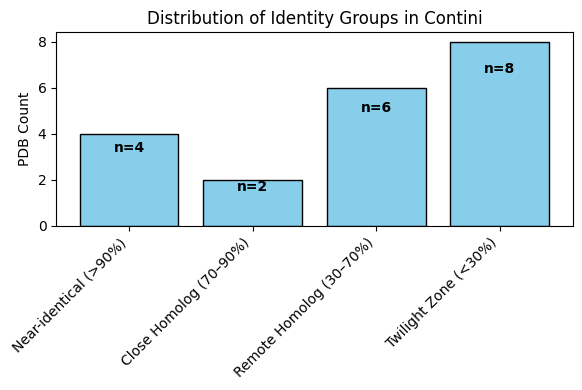

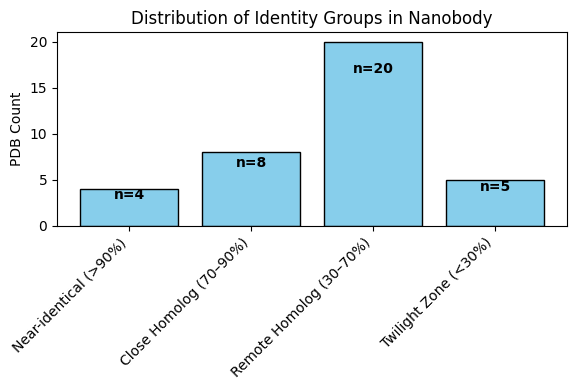

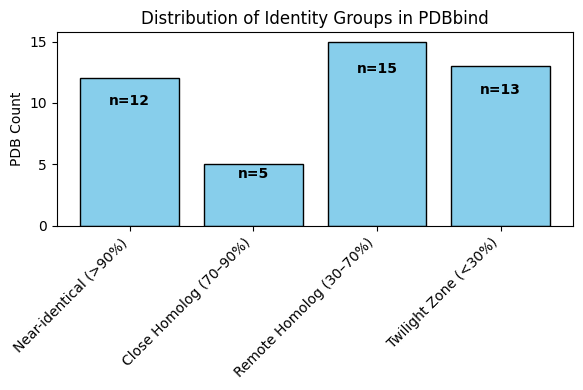

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load the CSV file ===
file_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/summary/identity_bin_counts_per_file.csv"
df = pd.read_csv(file_path)

# === Define the desired order of identity groups ===
order = [
    "Near-identical (>90%)",
    "Close Homolog (70–90%)",
    "Remote Homolog (30–70%)",
    "Twilight Zone (<30%)"
]

# === Plot distribution histograms for each file ===
files = df["file"].unique()

for f in files:
    subset = df[df["file"] == f].set_index("Identity Group").reindex(order).reset_index()
    
    plt.figure(figsize=(6, 4))
    bars = plt.bar(subset["Identity Group"], subset["PDB Count"], 
                   color="skyblue", edgecolor="black")
    
    # Annotate inside each bar
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, height * 0.85, 
                     f"n={int(height)}", ha='center', va='center', 
                     fontsize=10, color="black", fontweight="bold")
    
    plt.title(f"Distribution of Identity Groups in {f}")
    plt.ylabel("PDB Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

## merge exp dG 

In [72]:
import pandas as pd
from pathlib import Path

# Paths
contini_path = Path("/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/PDBbind.csv")
comparison_path = Path("/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/PDBbind_comparison.csv")
out_path = Path("/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/PDBbind_with_experimental_and_predicted.csv")

# Load
df_contini = pd.read_csv(contini_path)
df_comp = pd.read_csv(comparison_path)

# Standardize join keys
df_contini["PDB_ID"] = df_contini["Test Complex"].astype(str).str.strip().str.lower()
df_comp["PDB_ID"] = df_comp["PDB_ID"].astype(str).str.strip().str.lower()

# If duplicates in comparison, keep the first (or aggregate if you prefer)
df_comp_dedup = df_comp.drop_duplicates(subset=["PDB_ID"], keep="first")

# Merge: bring both 'experimental' and 'ANN_PREDICTED' into Contini
merged = df_contini.merge(
    df_comp_dedup[["PDB_ID", "experimental", "ANN_PREDICTED"]],
    on="PDB_ID",
    how="left",          # left join keeps all Contini rows
    validate="m:1"       # many-to-one: each Contini PDB maps to at most one comparison row
)

# Save
merged.to_csv(out_path, index=False)
print(f"✅ Saved merged file to: {out_path}")

✅ Saved merged file to: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/PDBbind_with_experimental_and_predicted.csv


In [73]:
import os
import pandas as pd
import numpy as np

# ---------- Config ----------
CSV_DIR = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder"      # <== change me
OUT_DIR = os.path.join(CSV_DIR, "summary") # where summary CSVs will be saved
os.makedirs(OUT_DIR, exist_ok=True)

# Biologically standard bins
BINS = [0, 30, 70, 90, 100]
LABELS = [
    "Twilight Zone (<30%)",
    "Remote Homolog (30–70%)",
    "Close Homolog (70–90%)",
    "Near-identical (>90%)",
]

# Column names expected (case-insensitive matching supported)
COL_IDENTITY = "Percent Identity"
COL_EXP = "experimental"
COL_PRED = "ANN_PREDICTED"

# ---------- Helpers ----------
def find_col(df, target_name):
    """Find a column by case-insensitive exact match; returns None if not found."""
    tl = target_name.lower()
    for c in df.columns:
        if str(c).lower() == tl:
            return c
    return None

def safe_numeric(s):
    return pd.to_numeric(s, errors="coerce")

def metrics(y_true, y_pred):
    """Return dict with n, MAE, RMSE, R, R2. NaN-safe; returns NaNs if <2 points for R."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y = y_true[mask]
    yhat = y_pred[mask]
    n = y.size
    if n == 0:
        return dict(n=0, MAE=np.nan, RMSE=np.nan, R=np.nan, R2=np.nan)
    mae = np.mean(np.abs(y - yhat))
    rmse = np.sqrt(np.mean((y - yhat) ** 2))
    # Pearson R and R^2
    if n >= 2 and np.std(y) > 0 and np.std(yhat) > 0:
        r = np.corrcoef(y, yhat)[0, 1]
    else:
        r = np.nan
    # R^2 as 1 - SSE/SST
    if n >= 1 and np.var(y) > 0:
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot
    else:
        r2 = np.nan
    return dict(n=int(n), MAE=mae, RMSE=rmse, R=r, R2=r2)

# ---------- Main aggregation ----------
counts_rows = []          # per file, per bin counts
metrics_overall_rows = [] # per file overall metrics
metrics_bins_rows = []    # per file, per bin metrics

for fname in os.listdir(CSV_DIR):
    if not fname.endswith(".csv"):
        continue
    fpath = os.path.join(CSV_DIR, fname)
    try:
        df = pd.read_csv(fpath)
    except Exception as e:
        print(f"⚠️ Skipping {fname}: read error: {e}")
        continue

    col_identity = find_col(df, COL_IDENTITY)
    col_exp = find_col(df, COL_EXP)
    col_pred = find_col(df, COL_PRED)

    missing = [name for name, c in [(COL_IDENTITY, col_identity), (COL_EXP, col_exp), (COL_PRED, col_pred)] if c is None]
    if missing:
        print(f"⚠️ Skipping {fname}: missing columns {missing}")
        continue

    # Coerce to numeric and bin
    df = df.copy()
    df[col_identity] = safe_numeric(df[col_identity])
    df[col_exp] = safe_numeric(df[col_exp])
    df[col_pred] = safe_numeric(df[col_pred])

    df["Identity Group"] = pd.cut(df[col_identity], bins=BINS, labels=LABELS, include_lowest=True)

    # Counts per bin
    counts = df["Identity Group"].value_counts().reindex(LABELS).fillna(0).astype(int)
    for label in LABELS:
        counts_rows.append({
            "file": fname,
            "Identity Group": label,
            "PDB Count": int(counts.loc[label]),
        })

    # Overall metrics for this file
    m_all = metrics(df[col_exp], df[col_pred])
    m_all.update({"file": fname})
    metrics_overall_rows.append(m_all)

    # Metrics per bin
    for label in LABELS:
        sub = df[df["Identity Group"] == label]
        m_bin = metrics(sub[col_exp], sub[col_pred])
        m_bin.update({"file": fname, "Identity Group": label})
        metrics_bins_rows.append(m_bin)

# ---------- Write summaries ----------
counts_df = pd.DataFrame(counts_rows).sort_values(["file", "Identity Group"])
overall_df = pd.DataFrame(metrics_overall_rows)[["file", "n", "MAE", "RMSE", "R", "R2"]].sort_values("file")
bybin_df = pd.DataFrame(metrics_bins_rows)[["file", "Identity Group", "n", "MAE", "RMSE", "R", "R2"]].sort_values(["file", "Identity Group"])

counts_path = os.path.join(OUT_DIR, "identity_bin_counts_per_file.csv")
overall_path = os.path.join(OUT_DIR, "metrics_overall_per_file.csv")
bybin_path = os.path.join(OUT_DIR, "metrics_by_identity_bin_per_file.csv")

counts_df.to_csv(counts_path, index=False)
overall_df.to_csv(overall_path, index=False)
bybin_df.to_csv(bybin_path, index=False)

print("✅ Done.")
print("Counts per bin:", counts_path)
print("Overall metrics:", overall_path)
print("By-bin metrics:", bybin_path)

✅ Done.
Counts per bin: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/summary/identity_bin_counts_per_file.csv
Overall metrics: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/summary/metrics_overall_per_file.csv
By-bin metrics: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/summary/metrics_by_identity_bin_per_file.csv


✅ Saved figure to: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/summary/seq_identity_small_multiples.png


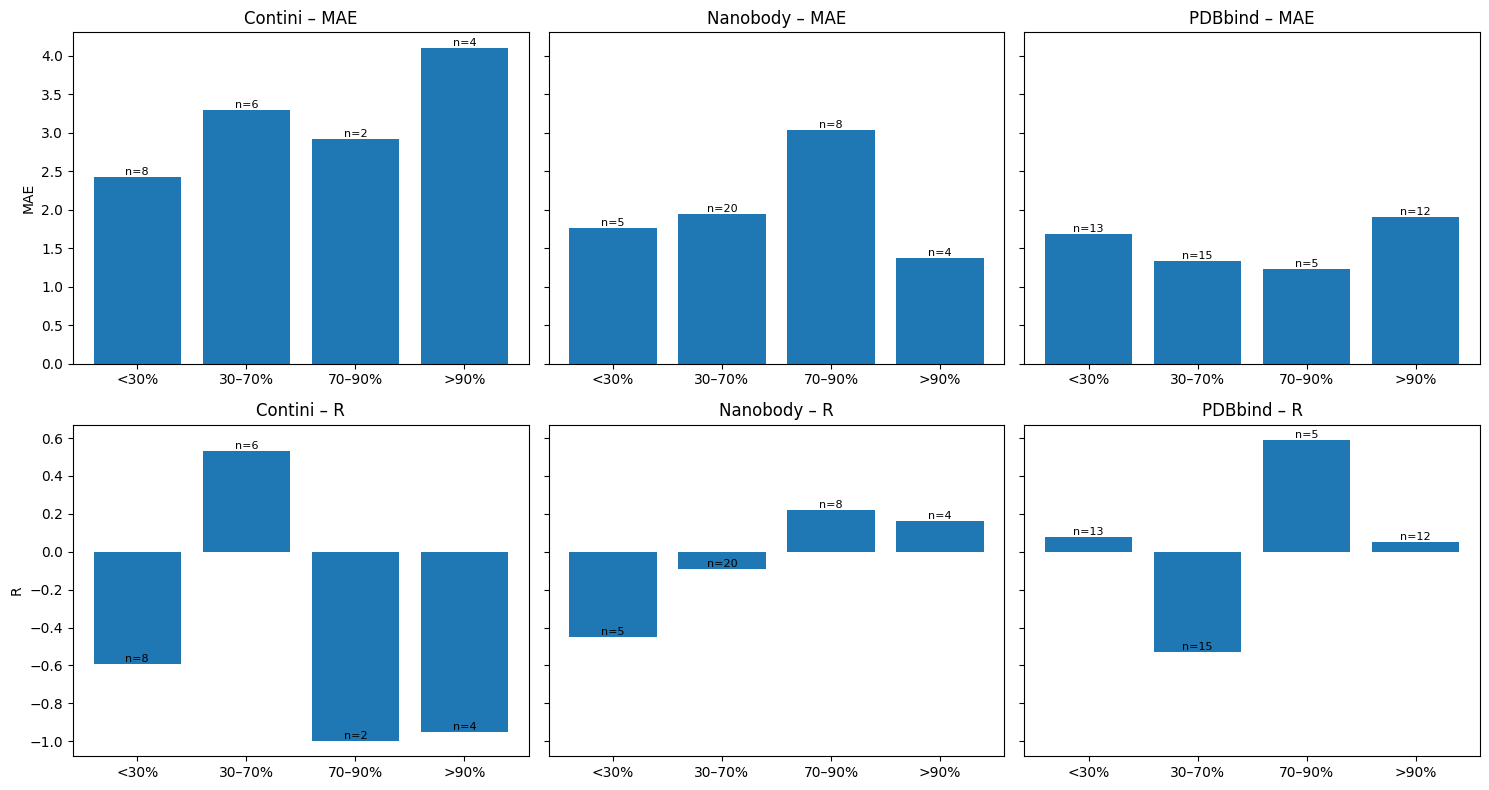

In [77]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt

# ======== Config ========
IN_CSV = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/complex_complex/untitled folder/summary/metrics_by_identity_bin_per_file.csv"  # change me
OUT_PNG = os.path.join(os.path.dirname(IN_CSV), "seq_identity_small_multiples.png")
DATASETS = ["Contini", "Nanobody", "PDBbind"]

# Identity group ordering and shorter labels for plotting
ORDER = [
    "Twilight Zone (<30%)",
    "Remote Homolog (30–70%)",
    "Close Homolog (70–90%)",
    "Near-identical (>90%)",
]
SHORT_LABELS = ["<30%", "30–70%", "70–90%", ">90%"]

# Robust mapping to handle dash inconsistencies
CANON = {
    "twilight zone (<30%)": "Twilight Zone (<30%)",
    "remote homolog (30-70%)": "Remote Homolog (30–70%)",
    "remote homolog (30–70%)": "Remote Homolog (30–70%)",
    "close homolog (70-90%)": "Close Homolog (70–90%)",
    "close homolog (70–90%)": "Close Homolog (70–90%)",
    "near-identical (>90%)": "Near-identical (>90%)",
}

def canon_group(s: str) -> str:
    if not isinstance(s, str):
        return s
    key = s.strip().replace("—", "-").replace("–", "-").lower()
    key = " ".join(key.split())
    return CANON.get(key, s.strip())

# ======== Load ========
df = pd.read_csv(IN_CSV)
df["Identity Group"] = df["Identity Group"].apply(canon_group)

for col in ["MAE", "RMSE", "R", "R2", "n"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df[df["testset"].isin(DATASETS) & df["Identity Group"].isin(ORDER)].copy()
df["Identity Group"] = pd.Categorical(df["Identity Group"], categories=ORDER, ordered=True)
df.sort_values(["testset", "Identity Group"], inplace=True)

# ======== Plot ========
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey="row")
metrics = ["MAE", "R"]

for row_idx, metric in enumerate(metrics):
    for col_idx, dataset in enumerate(DATASETS):
        ax = axes[row_idx, col_idx]
        sub = df[df["testset"] == dataset]

        x = range(len(ORDER))
        y = [sub.loc[sub["Identity Group"] == g, metric].values[0]
             if (sub["Identity Group"] == g).any() else float("nan") for g in ORDER]
        n_vals = [sub.loc[sub["Identity Group"] == g, "n"].values[0]
                  if (sub["Identity Group"] == g).any() else 0 for g in ORDER]

        ax.bar(x, y)

        # Annotate n above bars
        for xi, yi, n in zip(x, y, n_vals):
            if not (isinstance(yi, float) and math.isnan(yi)):
                ax.text(xi, yi, f"n={n}", ha="center", va="bottom", fontsize=8)

        ax.set_title(f"{dataset} – {metric}")
        ax.set_xticks(list(x))
        ax.set_xticklabels(SHORT_LABELS, rotation=0)
        if col_idx == 0:
            ax.set_ylabel(metric)
        else:
            ax.set_ylabel("")

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
print(f"✅ Saved figure to: {OUT_PNG}")
plt.show()

### check PDBs in training set

In [14]:
import os
from Bio import SeqIO, pairwise2
import pandas as pd
from itertools import combinations

def load_sequences_from_directory(fasta_dir):
    """Load all sequences from multi-entry FASTA files into a dict {(filename|record_id): sequence}"""
    sequences = {}
    for filename in os.listdir(fasta_dir):
        if filename.endswith(".fasta") or filename.endswith(".fa"):
            path = os.path.join(fasta_dir, filename)
            for record in SeqIO.parse(path, "fasta"):
                key = f"{filename}|{record.id}"
                sequences[key] = str(record.seq)
    return sequences

def compute_identity(seq1, seq2):
    """Compute global sequence identity (percent match over alignment length)"""
    alignment = pairwise2.align.globalxx(seq1, seq2, one_alignment_only=True)[0]
    matches = alignment[2]
    aligned_length = alignment[4]
    return matches / aligned_length if aligned_length > 0 else 0.0

# === Set directory ===
train_dir = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Training_set"

# === Load training sequences ===
train_seqs = load_sequences_from_directory(train_dir)

# === Compute pairwise identities among training sequences ===
results = []

for (name1, seq1), (name2, seq2) in combinations(train_seqs.items(), 2):
    identity = compute_identity(seq1, seq2)
    results.append({
        "Sequence 1": name1,
        "Sequence 2": name2,
        "Percent Identity": round(identity * 100, 2)
    })

# === Save results ===
df = pd.DataFrame(results)
output_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Training_set_pairwise_identity_internal.csv"
df.to_csv(output_path, index=False)

print(f"\n✅ Done. Results saved to: {output_path}")


✅ Done. Results saved to: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Training_set_pairwise_identity_internal.csv


### choose the highest similarity for each chain

In [19]:
import pandas as pd

# === Load training set sequence similarity CSV ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Training_set_pairwise_identity_internal.csv"  # 🔁 update this
df = pd.read_csv(csv_path)

# === Clean column names ===
df.columns = df.columns.str.strip()
df["Percent Identity"] = pd.to_numeric(df["Percent Identity"], errors="coerce")

# === Extract PDB ID from Sequence 1 ===
df["PDB_ID"] = df["Sequence 1"].str.extract(r"([0-9a-zA-Z]{4})", expand=False).str.lower()

# === Remove self-comparisons (optional safety check) ===
df = df[df["Sequence 1"] != df["Sequence 2"]]

# === Get max identity per unique sequence (Sequence 1) ===
max_identity = df.groupby("Sequence 1")["Percent Identity"].max().reset_index()

# === Define classification ===
def classify_identity(pct):
    if pct >= 90:
        return "High (>90%)"
    elif pct >= 30:
        return "Moderate (30-89%)"
    else:
        return "Low (<30%)"

max_identity["Identity Group"] = max_identity["Percent Identity"].apply(classify_identity)

# === Extract 4-letter PDB ID again for reporting
max_identity["PDB_ID"] = max_identity["Sequence 1"].str.extract(r"([0-9a-zA-Z]{4})", expand=False).str.lower()

# === Save result ===
output_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Training_set_grouped.csv"  # 🔁 update this
max_identity.to_csv(output_path, index=False)


# === Summary preview ===
print(max_identity.head())
print(max_identity["Identity Group"].value_counts())

                Sequence 1  Percent Identity     Identity Group PDB_ID
0  1E96.fasta|1E96_1|Chain             58.92  Moderate (30-89%)   1e96
1  1E96.fasta|1E96_2|Chain             25.95         Low (<30%)   1e96
2  1a22.fasta|1A22_1|Chain             93.91        High (>90%)   1a22
3  1a22.fasta|1A22_2|Chain             96.68        High (>90%)   1a22
4  1axi.fasta|1AXI_1|Chain             24.73         Low (<30%)   1axi
Identity Group
Low (<30%)           589
High (>90%)          235
Moderate (30-89%)    181
Name: count, dtype: int64


## group by high, moderate, and low

In [20]:
import pandas as pd

# === Load grouped training identity results ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Training_set_grouped.csv"  # 🔁 Replace with your actual path
df = pd.read_csv(csv_path)

# === Clean column names (if needed) ===
df.columns = df.columns.str.strip()

# === For each PDB_ID, keep the row with the highest Percent Identity ===
df_max_per_pdb = df.sort_values(by=["PDB_ID", "Percent Identity"], ascending=[True, False]) \
                   .drop_duplicates(subset=["PDB_ID"], keep="first")

# === Optional: sort by identity score descending for viewing
df_max_per_pdb = df_max_per_pdb.sort_values(by="Percent Identity", ascending=False)

# === Save result
output_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/training_identity_max_per_pdb.csv"  # 🔁 Replace
df_max_per_pdb.to_csv(output_path, index=False)

# === Preview summary
print(df_max_per_pdb.head())
print(df_max_per_pdb["Identity Group"].value_counts())

                  Sequence 1  Percent Identity Identity Group PDB_ID
644  4q5u.fasta|4Q5U_1|Chain             100.0    High (>90%)   4q5u
799  5lz6.fasta|5LZ6_1|Chain             100.0    High (>90%)   5lz6
186  2omv.fasta|2OMV_1|Chain             100.0    High (>90%)   2omv
183  2omt.fasta|2OMT_2|Chain             100.0    High (>90%)   2omt
626  4ol0.fasta|4OL0_1|Chain             100.0    High (>90%)   4ol0
Identity Group
Low (<30%)           228
High (>90%)          175
Moderate (30-89%)    101
Name: count, dtype: int64


## plot and counts

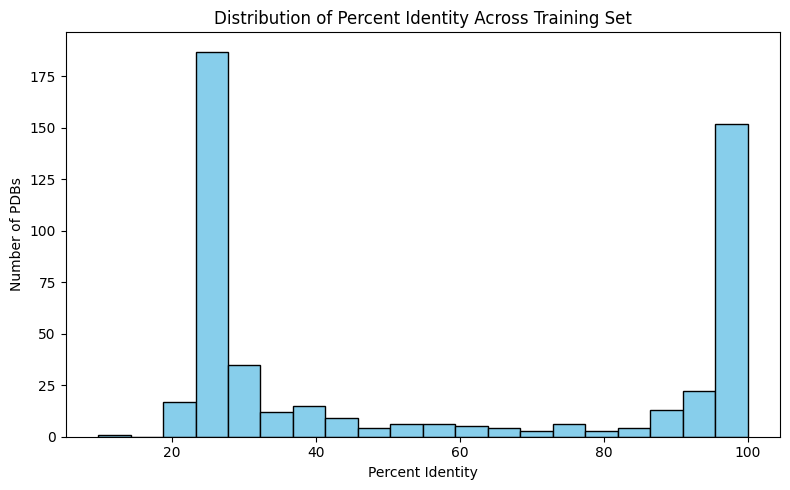

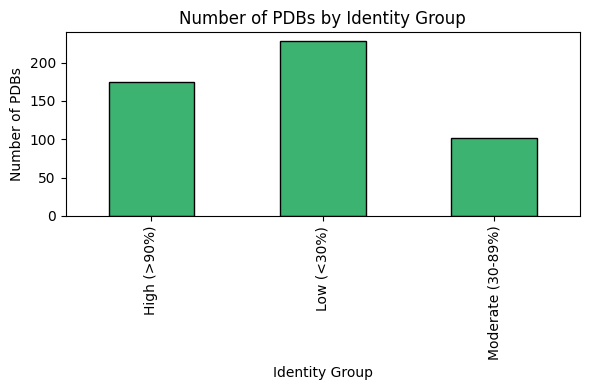


Identity Group Counts:
Identity Group
High (>90%)          175
Low (<30%)           228
Moderate (30-89%)    101
Name: count, dtype: int64


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSV ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/training_identity_max_per_pdb.csv"  # 🔁 Replace
df = pd.read_csv(csv_path)

# === Ensure percent identity is numeric ===
df["Percent Identity"] = pd.to_numeric(df["Percent Identity"], errors="coerce")

# === Plot 1: Histogram of Percent Identity ===
plt.figure(figsize=(8, 5))
plt.hist(df["Percent Identity"], bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Percent Identity")
plt.ylabel("Number of PDBs")
plt.title("Distribution of Percent Identity Across Training Set")
plt.tight_layout()
#plt.savefig("/mnt/data/percent_identity_histogram.png")
plt.show()

# === Plot 2: Bar plot for Identity Groups ===
plt.figure(figsize=(6, 4))
group_counts = df["Identity Group"].value_counts().sort_index()
group_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.xlabel("Identity Group")
plt.ylabel("Number of PDBs")
plt.title("Number of PDBs by Identity Group")
plt.tight_layout()
#plt.savefig("/mnt/data/identity_group_barplot.png")
plt.show()

# === Print group counts ===
print("\nIdentity Group Counts:")
print(group_counts)

# Histrogram to plot distribution

Plot saved to: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/PDBbind_sequence_identity_histogram.png


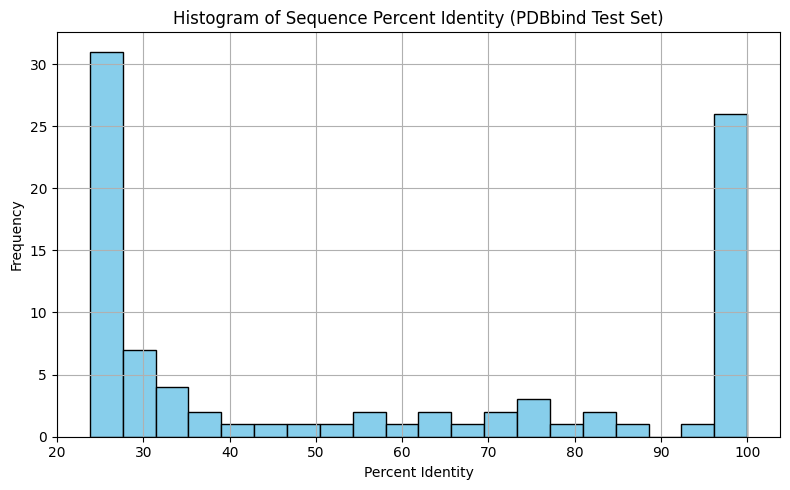

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load the CSV ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/PDBbind_sequence_identity_results.csv"
df = pd.read_csv(csv_path)

# === Extract Percent Identity ===
percent_identities = df["Percent Identity"]

# === Plot histogram ===
plt.figure(figsize=(8, 5))
plt.hist(percent_identities, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Percent Identity")
plt.ylabel("Frequency")
plt.title("Histogram of Sequence Percent Identity (PDBbind Test Set)")
plt.grid(True)
plt.tight_layout()

output_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/PDBbind_sequence_identity_histogram.png"
plt.savefig(output_path, dpi=300)
print(f"Plot saved to: {output_path}")

plt.show()



# group PDBs by high, moderate, and low similarities
I ensured that each PDB only belongs to its highest identity match group (i.e., if a PDB has any match ≥90%, it should only appear in the High group and not duplicated in Moderate or Low)

## Contini 

In [11]:
import pandas as pd

# === Load your sequence identity file ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Contini_sequence_identity_results.csv"
df = pd.read_csv(csv_path)

# === Clean column names ===
df.columns = df.columns.str.strip()
df["Percent Identity"] = pd.to_numeric(df["Percent Identity"], errors="coerce")

# === Extract 4-character PDB ID ===
df["PDB_ID"] = df["Test Sequence"].str.extract(r"([0-9a-zA-Z]{4})", expand=False).str.lower()

# === Get max identity per PDB and assign group ===
max_identity = df.groupby("PDB_ID")["Percent Identity"].max().reset_index()
def classify_identity(pct):
    if pct >= 90:
        return "High (≥90%)"
    elif pct >= 30:
        return "Moderate (30–89%)"
    else:
        return "Low (<30%)"
max_identity["Identity Group"] = max_identity["Percent Identity"].apply(classify_identity)

# === Merge back the group info, drop duplicates ===
df_unique = df.drop_duplicates(subset=["PDB_ID"]).drop(columns=["Percent Identity"])
df_final = pd.merge(df_unique, max_identity, on="PDB_ID")

# === Save final cleaned version ===
output_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Contini_identity_grouped_unique.csv"
df_final.to_csv(output_path, index=False)

# === Preview ===
print(df_final.head())
print(df_final["Identity Group"].value_counts())

             Test Sequence Best Matching Train Sequence PDB_ID  \
0  1kac.fasta|1KAC_2|Chain      1p6a.fasta|1P6A_2|Chain   1kac   
1  2oob.fasta|2OOB_2|Chain      2c7m.fasta|2C7M_2|Chain   2oob   
2  1emv.fasta|1EMV_1|Chain      2vln.fasta|2VLN_1|Chain   1emv   
3  2uuy.fasta|2UUY_1|Chain      1g9i.fasta|1G9I_1|Chain   2uuy   
4  3bzd.fasta|3BZD_2|Chain      2aq2.fasta|2AQ2_2|Chain   3bzd   

   Percent Identity Identity Group  
0            100.00    High (≥90%)  
1            100.00    High (≥90%)  
2            100.00    High (≥90%)  
3            100.00    High (≥90%)  
4             99.16    High (≥90%)  
Identity Group
High (≥90%)          8
Low (<30%)           7
Moderate (30–89%)    5
Name: count, dtype: int64


## Nanobody

In [12]:
import pandas as pd

# === Load your sequence identity file ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Nanobody_sequence_identity_results.csv"
df = pd.read_csv(csv_path)

# === Clean column names ===
df.columns = df.columns.str.strip()
df["Percent Identity"] = pd.to_numeric(df["Percent Identity"], errors="coerce")

# === Extract 4-character PDB ID ===
df["PDB_ID"] = df["Test Sequence"].str.extract(r"([0-9a-zA-Z]{4})", expand=False).str.lower()

# === Get max identity per PDB and assign group ===
max_identity = df.groupby("PDB_ID")["Percent Identity"].max().reset_index()
def classify_identity(pct):
    if pct >= 90:
        return "High (≥90%)"
    elif pct >= 30:
        return "Moderate (30–89%)"
    else:
        return "Low (<30%)"
max_identity["Identity Group"] = max_identity["Percent Identity"].apply(classify_identity)

# === Merge back the group info, drop duplicates ===
df_unique = df.drop_duplicates(subset=["PDB_ID"]).drop(columns=["Percent Identity"])
df_final = pd.merge(df_unique, max_identity, on="PDB_ID")

# === Save final cleaned version ===
output_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Nanobody_identity_grouped_unique.csv"
df_final.to_csv(output_path, index=False)

# === Preview ===
print(df_final.head())
print(df_final["Identity Group"].value_counts())

              Test Sequence Best Matching Train Sequence PDB_ID  \
0  1bzq.fasta|1BZQ_1|Chains      2p44.fasta|2P44_1|Chain   1bzq   
1   1rjc.fasta|1RJC_2|Chain      1zvy.fasta|1ZVY_2|Chain   1rjc   
2  4i0c.fasta|4I0C_1|Chains      3eba.fasta|3EBA_2|Chain   4i0c   
3  4x7f.fasta|4X7F_1|Chains      5omn.fasta|5OMN_1|Chain   4x7f   
4   1op9.fasta|1OP9_2|Chain      3eba.fasta|3EBA_2|Chain   1op9   

   Percent Identity Identity Group  
0             100.0    High (≥90%)  
1             100.0    High (≥90%)  
2             100.0    High (≥90%)  
3             100.0    High (≥90%)  
4             100.0    High (≥90%)  
Identity Group
Moderate (30–89%)    20
High (≥90%)          17
Name: count, dtype: int64


## PDBbind

In [13]:
import pandas as pd

# === Load your sequence identity file ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/PDBbind_sequence_identity_results.csv"
df = pd.read_csv(csv_path)

# === Clean column names ===
df.columns = df.columns.str.strip()
df["Percent Identity"] = pd.to_numeric(df["Percent Identity"], errors="coerce")

# === Extract 4-character PDB ID ===
df["PDB_ID"] = df["Test Sequence"].str.extract(r"([0-9a-zA-Z]{4})", expand=False).str.lower()

# === Get max identity per PDB and assign group ===
max_identity = df.groupby("PDB_ID")["Percent Identity"].max().reset_index()
def classify_identity(pct):
    if pct >= 90:
        return "High (≥90%)"
    elif pct >= 30:
        return "Moderate (30–89%)"
    else:
        return "Low (<30%)"
max_identity["Identity Group"] = max_identity["Percent Identity"].apply(classify_identity)

# === Merge back the group info, drop duplicates ===
df_unique = df.drop_duplicates(subset=["PDB_ID"]).drop(columns=["Percent Identity"])
df_final = pd.merge(df_unique, max_identity, on="PDB_ID")

# === Save final cleaned version ===
output_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/PDBbind_identity_grouped_unique.csv"
df_final.to_csv(output_path, index=False)

# === Preview ===
print(df_final.head())
print(df_final["Identity Group"].value_counts())

              Test Sequence Best Matching Train Sequence PDB_ID  \
0   6ne2.fasta|6NE2_2|Chain      6ne4.fasta|6NE4_2|Chain   6ne2   
1   5ky4.fasta|5KY4_1|Chain      5ky0.fasta|5KY0_1|Chain   5ky4   
2   6jb2.fasta|6JB2_2|Chain      1zvy.fasta|1ZVY_2|Chain   6jb2   
3  4uyp.fasta|4UYP_1|Chains      4uyq.fasta|4UYQ_1|Chain   4uyp   
4   4m0w.fasta|4M0W_2|Chain      2c7m.fasta|2C7M_2|Chain   4m0w   

   Percent Identity Identity Group  
0             100.0    High (≥90%)  
1             100.0    High (≥90%)  
2             100.0    High (≥90%)  
3             100.0    High (≥90%)  
4             100.0    High (≥90%)  
Identity Group
High (≥90%)          19
Moderate (30–89%)    14
Low (<30%)           12
Name: count, dtype: int64


In [49]:
import pandas as pd

# === File paths ===
identity_csv = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/testset_similarity_report/PDBbind_identity_grouped_unique.csv"       # 🔁 UPDATE
comparison_csv = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/PDBbind_comparison.csv"                   # 🔁 UPDATE

# === Load the identity group CSV ===
df_identity = pd.read_csv(identity_csv)
df_identity["PDB_ID"] = df_identity["PDB_ID"].str.lower().str.strip()

# === Load the comparison CSV (predicted + experimental values) ===
df_comparison = pd.read_csv(comparison_csv)
df_comparison["PDB_ID"] = df_comparison["PDB_ID"].str.lower().str.strip()

# === Merge the two files on PDB_ID ===
df_updated = pd.merge(df_identity, df_comparison[["PDB_ID", "ANN_PREDICTED", "experimental"]],
                      on="PDB_ID", how="left")

# === Overwrite the original CSV file with added columns ===
df_updated.to_csv(identity_csv, index=False)
print(f"✅ Successfully updated: {identity_csv}")

# === Preview ===
print(df_updated.head())

✅ Successfully updated: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/testset_similarity_report/PDBbind_identity_grouped_unique.csv
              Test Sequence Best Matching Train Sequence PDB_ID  \
0   6ne2.fasta|6NE2_2|Chain      6ne4.fasta|6NE4_2|Chain   6ne2   
1   5ky4.fasta|5KY4_1|Chain      5ky0.fasta|5KY0_1|Chain   5ky4   
2   6jb2.fasta|6JB2_2|Chain      1zvy.fasta|1ZVY_2|Chain   6jb2   
3  4uyp.fasta|4UYP_1|Chains      4uyq.fasta|4UYQ_1|Chain   4uyp   
4   4m0w.fasta|4M0W_2|Chain      2c7m.fasta|2C7M_2|Chain   4m0w   

   Percent Identity Identity Group  ANN_PREDICTED  experimental  
0             100.0    High (≥90%)      -9.928999        -12.11  
1             100.0    High (≥90%)      -9.906647         -7.95  
2             100.0    High (≥90%)      -9.741429         -8.09  
3             100.0    High (≥90%)      -9.641465        -14.58  
4             100.0   

In [54]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# === Load CSV with grouped PDBs and affinity values ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/testset_similarity_report/PDBbind_identity_grouped_unique.csv"  # 🔁 UPDATE path
df = pd.read_csv(csv_path)

# Clean columns just in case
df["PDB_ID"] = df["PDB_ID"].str.lower().str.strip()
df = df.dropna(subset=["ANN_PREDICTED", "experimental", "Identity Group"])

# === Function to compute stats per group ===
def compute_stats(group):
    y_true = group["experimental"]
    y_pred = group["ANN_PREDICTED"]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r_value, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    group = group.copy()
    group["MAE"] = mae
    group["RMSE"] = rmse
    group["R"] = r_value
    group["R2"] = r2

    return group

# === Apply per identity group ===
df_stats = df.groupby("Identity Group", group_keys=False).apply(compute_stats)

# === Save updated CSV ===
df_stats.to_csv(csv_path, index=False)
print(f"✅ Updated CSV with stats saved to: {csv_path}")

df_stats

# === Preview ===
print(df_stats[["PDB_ID", "Identity Group", "MAE", "RMSE", "R", "R2"]].drop_duplicates("Identity Group"))

✅ Updated CSV with stats saved to: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/testset_similarity_report/PDBbind_identity_grouped_unique.csv
   PDB_ID     Identity Group       MAE      RMSE         R        R2
0    6ne2        High (≥90%)  1.737086  2.087039 -0.153762 -0.042273
18   4cj2  Moderate (30–89%)  1.173367  1.394402 -0.308973 -0.139393
32   3wqb         Low (<30%)  1.808606  2.246271  0.085534 -0.062914


/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/l3/px3tmzm113q8q08w_5t0ktkm0000gn/T/ipykernel_60311/3794743122.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

## Compare missing residues between PDB and FASTA

In [35]:
import os
import pandas as pd
from Bio.PDB import PDBParser
from Bio import SeqIO
import requests

# === Parameters ===
csv_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/PDBbind_comparison.csv"  # 🔁 Replace with your CSV path
pdb_dir = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/PDBbind/pdb_files"
fasta_dir = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/PDBbind"
output_csv = "missing_residue_report.csv"

# === Create directory for downloaded PDBs ===
os.makedirs(pdb_dir, exist_ok=True)

# === Load PDB IDs ===
df = pd.read_csv(csv_path)
df["PDB_ID"] = df["PDB_ID"].str.lower().str.strip()
pdb_ids = df["PDB_ID"].dropna().unique()

# === Setup parser ===
parser = PDBParser(QUIET=True)

# === Store results ===
results = []

# === Main loop ===
for pdb_id in pdb_ids:
    print(f"Processing {pdb_id}...")

    # --- Download PDB ---
    pdb_path = os.path.join(pdb_dir, f"{pdb_id}.pdb")
    if not os.path.exists(pdb_path):
        url = f"https://files.rcsb.org/download/{pdb_id.upper()}.pdb"
        r = requests.get(url)
        if r.status_code == 200:
            with open(pdb_path, "w") as f:
                f.write(r.text)
        else:
            print(f"❌ Failed to download {pdb_id}")
            continue

    # --- Load FASTA ---
    fasta_path = os.path.join(fasta_dir, f"{pdb_id}.fasta")
    if not os.path.exists(fasta_path):
        print(f"⚠️ Missing FASTA for {pdb_id}, skipping...")
        continue

    try:
        records = list(SeqIO.parse(fasta_path, "fasta"))
    except Exception as e:
        print(f"⚠️ Error parsing FASTA for {pdb_id}: {e}")
        continue

    try:
        structure = parser.get_structure(pdb_id, pdb_path)
    except Exception as e:
        print(f"⚠️ Error parsing PDB {pdb_id}: {e}")
        continue

    for record in records:
        fasta_seq = str(record.seq)
        fasta_len = len(fasta_seq)

        # Extract chain ID from FASTA header (e.g., ">1A22_1|Chain A")
        chain_id = None
        if "Chain" in record.description:
            parts = record.description.split("Chain")
            if len(parts) > 1:
                chain_id = parts[1].strip()[0]

        if not chain_id:
            print(f"⚠️ Could not parse chain from {record.description}, skipping chain")
            continue

        # Get observed residues in structure
        try:
            model = structure[0]
            if chain_id not in model:
                print(f"⚠️ Chain {chain_id} not found in {pdb_id}")
                continue

            chain = model[chain_id]
            pdb_residues = [residue.id[1] for residue in chain if residue.id[0] == ' ']
            observed_set = set(pdb_residues)
            expected_set = set(range(1, fasta_len + 1))
            missing = sorted(expected_set - observed_set)

            results.append({
                "PDB_ID": pdb_id,
                "Chain": chain_id,
                "FASTA_Length": fasta_len,
                "PDB_Residues": len(pdb_residues),
                "Missing_Count": len(missing),
                "Missing_Positions": ",".join(map(str, missing)) if missing else "None"
            })
        except Exception as e:
            print(f"⚠️ Error processing chain {chain_id} in {pdb_id}: {e}")
            continue

# === Save result ===
df_result = pd.DataFrame(results)
df_result.to_csv(output_csv, index=False)
print(f"\n✅ Report saved to: {output_csv}")

Processing 2wh6...
Processing 2wp3...
⚠️ Chain A not found in 2wp3
⚠️ Chain B not found in 2wp3
Processing 3wqb...
Processing 4b1y...
⚠️ Chain A not found in 4b1y
Processing 4cj0...
Processing 4cj2...
⚠️ Chain s not found in 4cj2
⚠️ Chain s not found in 4cj2
Processing 4k5a...
Processing 4kt3...
Processing 4lzx...
Processing 4m0w...
Processing 4nl9...
⚠️ Chain s not found in 4nl9
⚠️ Chain s not found in 4nl9
Processing 4pj2...
⚠️ Chain s not found in 4pj2
⚠️ Chain s not found in 4pj2
Processing 4qlp...
Processing 4uyp...
⚠️ Chain s not found in 4uyp
⚠️ Chain s not found in 4uyp
Processing 4wnd...
Processing 4x33...
Processing 4yl8...
Processing 4z99k...
❌ Failed to download 4z99k
Processing 5b78...
Processing 5dc4...
Processing 5djt...
Processing 5.00e+95...
❌ Failed to download 5.00e+95
Processing 5ep6...
⚠️ Chain s not found in 5ep6
⚠️ Chain s not found in 5ep6
Processing 5h3j...
Processing 5inb...
Processing 5ma4...
Processing 5nt7...
⚠️ Chain s not found in 5nt7
⚠️ Chain s not foun

## Find Remark in .PDB for missing residues

In [55]:
import os
import pandas as pd
import re

def count_missing_residues(pdb_file_path):
    """Counts REMARK 465 missing residues from a PDB file."""
    count = 0
    with open(pdb_file_path, 'r') as file:
        for line in file:
            if line.startswith("REMARK 465"):
                if len(line) > 30 and re.match(r"REMARK 465\s+([A-Z]{3})\s+([A-Z0-9])\s+(\d+)", line):
                    count += 1
    return count

def process_pdb_folder(folder_path):
    """Processes PDB files and reports how many missing residues per PDB."""
    results = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdb"):
            pdb_path = os.path.join(folder_path, filename)
            pdb_id = os.path.splitext(filename)[0]
            count = count_missing_residues(pdb_path)
            results.append({
                "PDB_ID": pdb_id,
                "Missing Residue Count": count,
                "Has Missing Residue": count > 0
            })
    return pd.DataFrame(results)

# === USAGE ===
pdb_folder = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Benchmark_PDB"
output_csv = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/Benchmark_missing_residues_summary.csv"

df_summary = process_pdb_folder(pdb_folder)
df_summary.to_csv(output_csv, index=False)

print(f"✅ Done. Summary saved to {output_csv}")

✅ Done. Summary saved to /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/Benchmark_missing_residues_summary.csv


## Convert a batch of FASTA to JSON for AlphaFold

In [41]:
from Bio import SeqIO
import json

# === Input/Output ===
fasta_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Contini/1acb.fasta"  # 🔁 Replace with your FASTA file
output_json_path = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Contini/JSON/1acb.json"         # 🔁 Output file name

# === Load sequences from FASTA ===
records = list(SeqIO.parse(fasta_path, "fasta"))

# === Build AlphaFold-compliant JSON ===
job = {
    "name": "AlphaFold Prediction Job",
    "modelSeeds": [],
    "sequences": [],
    "dialect": "alphafoldserver",
    "version": 1
}

for record in records:
    job["sequences"].append({
        "proteinChain": {
            "sequence": str(record.seq),
            "count": 1  # Default count
            # Optionally add: "maxTemplateDate": "YYYY-MM-DD"
        }
    })

# === Save JSON ===
with open(output_json_path, "w") as f:
    json.dump([job], f, indent=2)

print(f"✅ Converted {len(records)} sequences to AlphaFold JSON format.")
print(f"📄 Output saved to: {output_json_path}")

✅ Converted 2 sequences to AlphaFold JSON format.
📄 Output saved to: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Contini/JSON/1acb.json


In [57]:
import os
import json
from Bio import SeqIO

# === Set your FASTA folder and output path ===
fasta_dir = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Benchmark_FASTA"  # 🔁 Change this to your folder
output_json = "/Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Benchmark_alpha_fold_jobs.json"  # 🔁 Change this to your desired output file

# === Collect all jobs ===
jobs = []

for file in os.listdir(fasta_dir):
    if file.endswith(".fasta") or file.endswith(".fa"):
        fasta_path = os.path.join(fasta_dir, file)
        pdb_id = os.path.splitext(file)[0].upper()  # Strip .fasta, uppercase
        job = {
            "name": f"{pdb_id}_AF",
            "modelSeeds": [],
            "sequences": [],
            "dialect": "alphafoldserver",
            "version": 1
        }
        
        # Parse all sequences in the file
        for record in SeqIO.parse(fasta_path, "fasta"):
            job["sequences"].append({
                "proteinChain": {
                    "sequence": str(record.seq),
                    "count": 1
                }
            })
        
        jobs.append(job)

# === Write to JSON ===
with open(output_json, "w") as f:
    json.dump(jobs, f, indent=2)

print(f"✅ Converted {len(jobs)} FASTA files into AlphaFold JSON jobs.")
print(f"📄 Output saved to: {output_json}")

✅ Converted 12 FASTA files into AlphaFold JSON jobs.
📄 Output saved to: /Users/qingshuzhao/Library/CloudStorage/OneDrive-SharedLibraries-UWM/Arjun Saha - qingshu_project/Rosetta_derived_feature_ANN/Paper/top_504_PDBs_20250309_2241/fasta_sequences/Benchmark_alpha_fold_jobs.json
